In [25]:
from astropy.io import fits
from IPython.display import Image
import pytwr
%pylab
%matplotlib inline

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [26]:
from platform import python_version

print(python_version())

3.8.10


In [27]:
#!/usr/bin/env python
# coding: utf-8

# # pydisc Notebook - 1.0

# ## 1 - Introduction

# *pydisc* is a python package meant to ease the use the manipulation of maps and profiles and the computation of basic quantities pertaining to galactic Discs. In this Notebook, I will show you how to use the main functionalities of *pydisc*.

# ## 2 - Structures in *pydisc*

# ### DataMaps, DataProfiles, Maps and Profiles

# In the language of *pydisc*:
# - **DataMaps** are data on a grid (hence 2D), e.g., values like velocities, flux, etc. The grid on which it is defined should be regular.
# - **DataProfiles** are data on a radial profile (hence 1D).
# - **Maps** are then a **set of** *DataMaps* associated with a set of coordinates X, Y.
# - **Profiles** are then a **set of** *DataProfiles* associated with a set of radial coordinates R.
# 
# DataMaps have orientations defined as 'NE_direct' indicating if the North-to-East axis is direct (counter-clockwise) or indirect (clockwise). It also has an 'alpha_North' angle which provides the angle between the North and the top (positive y-axis). DataMaps also have a pixelscale which provides the conversion between arcseconds and pixels in case the X,Y grids are not defined. If this is the case, X, and Y will be computed using just the indices from the grid.
# 
# DataMaps and DataProfiles have 'units' as defined by astropy units. These should be compatible with e.g., arcseconds, so these are observational. 
# 
# DataMap arguments:
# - dunit: astropy unit
# - order: velocity moment order. Hence velocities are order=1, flux or mass is 0, dispersion is 2, anything else would be -1 and there is a category for "dummy" maps with order=-10.
# - dname: name of the datamap
# - flag: a flag which is meant to add info (string)
# - data and edata: numpy arrays. If edata is not provided, it will be defined as None.
# 
# DataProfiles have similar arguments, but with punit (profile unit) and pname.
# 
# Maps arguments:
# - name: name of the map
# - X and Y: the 2 main arrays. If not provided, indices will be used.
# - Xcen and Ycen: centre for the 0,0
# - XYunit: unit (astropy) for the X and Y axis
# - NE_direct, alpha_North, etc.
# 
# Note that a Map can have many datamaps: hence a set of X,Y can have many data associated to it (sharing the same coordinates), each one having a different dname, order, flag etc.

# ### Galaxy

# A 'Galaxy' is an object which has some characteristics like: a distance, a Position Angle for the line of Nodes, an inclination (in degrees) and the Position Angle for a bar if present.

# ### GalacticDisc

# A 'GalacticDisc' is a structure associating a set of Maps and Profiles and a given Galaxy. 
# 
# This is the main structure which we will be using for the calculation of various quantities. 
# 
# There are a number of associated classes, namely:
# - 'DensityWave': associated with methods for density waves like the Tremaine Weinberg method
# - 'GalacticTorque': associated with methods for deriving torques
# 
# all inheriting from the GalacticDisc class, thus sharing a number of functionalities, but also have their own specific ones (which require a set of maps).
#     
# The 'grammar' for maps and datamaps is simple (a priori):
# - if you have an attribute like "data" you can input this in the argument list as:
# "data<map_name>_<datamap_name>". Hence if the map is name "MUSE" and the datamap named "vstar" you should have an argument for the data as "dataMUSE_vstar" and the associated "edataMUSE_vstar" if you have uncertainties for this map etc. Same applies for all argument of the maps and data, for example (using the same example): orderMUSE_vstar, XMUSE, YMUSE, XcenMUSE, YcenMUSE, flagMUSE_vstar...
# - In this way you can have several datamaps attached to a single map and have e.g.,: XMUSE, YMUSE, dataMUSE_vstar, dataMUSE_gas, dataMUSE_...
# 

# # 3- Examples

# ## 3.1 - Tremaine Weinberg

# Here is an example of how to get a Tremaine-Weinberg calculation made on a set of maps using the *DensityWave* class.

# In[13]:


# Importing the package and the DensityWave class
import src.pydisc as pydisc
from src.pydisc.density_wave import DensityWave

# Importing useful modules 
from astropy.io import fits as pyfits
from os.path import join as joinpath
import numpy as np

In [29]:
D = 9.84 # Mpc
dist_scale = (D*1000*2*np.pi)/(360*60*60.) #kpc/arcsec
bima_scale = 1. # arcsec/pix

pix_kpc = bima_scale*dist_scale # kpc/pix

PA = 20.7 # deg

image_center = ( 180, 177.5) # image center in pix

incl = 8.9 # deg

v_syst = 657. # km/s, see Table 1 in arxiv.org/pdf/astro-ph/0304294.pdf

In [30]:
fname = './data/NGC0628.bima12m.gmom1.fits'
mom1data = fits.getdata(fname)
mom1data[np.isnan(mom1data)] = 0.

fname = './data/NGC0628.bima12m.mmom0.fits'
mom0data = fits.getdata(fname)
mom0data[np.isnan(mom0data)] = 0.000000001
mom0data[mom0data < 0.] = 0.000000001


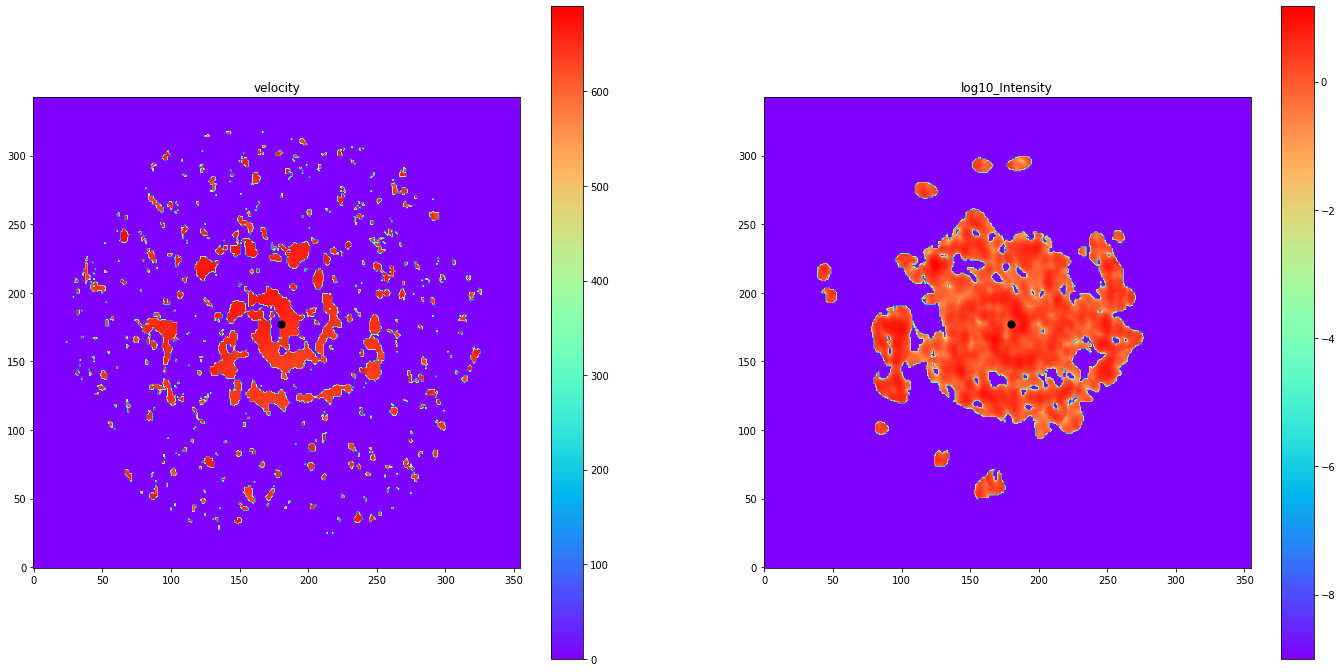

(1, 1, 343, 355)

In [31]:
fig = plt.figure(figsize=[24,12])
ax = plt.subplot(121)
im = ax.imshow(np.squeeze(mom1data), origin='lower', cmap='rainbow')
fig.colorbar(im, ax=ax)
ax.scatter(image_center[0], image_center[1], 50, 'k')
ax.set_title('velocity')

ax = plt.subplot(122)
im = plt.imshow(np.squeeze(np.log10(mom0data)), origin='lower', cmap='rainbow')
fig.colorbar(im, ax=ax)
ax.scatter(image_center[0], image_center[1], 50, 'k')
ax.set_title('log10_Intensity')

plt.show()
shape(mom0data)

In [33]:
plane_v = np.zeros((343, 355))
plane_intens = np.zeros((343, 355))
plane_v = pytwr.rotate_image(mom1data[0,0,:,:], angle=20.7+90., center=image_center)
plane_intens = pytwr.rotate_image(mom0data[0,0,:,:], angle=20.7+90, center=image_center)

In [34]:
plane_v = mom1data[0,0,:,:]
plane_intens = mom0data[0,0,:,:]

In [35]:
plane_v = plane_v - v_syst
plane_v[plane_v < -v_syst+0.001] = 0. # to keep all pixs with zero signal

In [36]:
# Getting the data
# ddata = "/home/science/PHANGS/MUSE/MUSEDAP/"
# n1512 = "NGC1512_MAPS.fits"
# Open the Maps files
# maps = pyfits.open(joinpath(ddata, n1512))
# Extract the mass, flux, and velocity maps
# mass = maps['STELLAR_MASS_DENSITY'].data
# flux = maps['FLUX'].data
# vel = maps['V_STARS'].data

mass = plane_intens
flux = plane_intens
vel = plane_v

In [37]:
# In[14]:


# mname is for mapname. 
mydisc = DensityWave(data_flux=flux, edata_flux=np.zeros_like(flux),
                     data_mass=mass, data_vel=vel, edata_vel=np.zeros_like(vel),
                     mname="N0628", Xcen=image_center[0], Ycen=image_center[1], PAnodes=90, distance=D, inclin=incl)

INFO: Attaching datamap flux of type INT (unit = solLum)
INFO: Attaching datamap mass of type INT (unit = solMass)
INFO: Attaching datamap vel of type NA (unit = km / s)
INFO: attaching map N0628


In [38]:
# In[15]:


# We can now look at the structure itself. 'mydisc' has a one map, which is named 'MUSE'. 
# This map is in a dictionary and is a Map class, as shown when printing it.
mydisc.maps

{'N0628': <src.pydisc.disc_data.Map at 0x7f82dcc8d040>}

In [39]:
# In[16]:


# We can also find out about the other variables:
mydisc.maps['N0628'].X

array([[-180., -179., -178., ...,  172.,  173.,  174.],
       [-180., -179., -178., ...,  172.,  173.,  174.],
       [-180., -179., -178., ...,  172.,  173.,  174.],
       ...,
       [-180., -179., -178., ...,  172.,  173.,  174.],
       [-180., -179., -178., ...,  172.,  173.,  174.],
       [-180., -179., -178., ...,  172.,  173.,  174.]], dtype=float32)

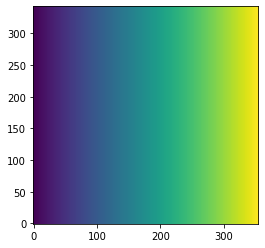

In [40]:
plt.imshow(mydisc.maps['N0628'].X, origin='lower')

In [41]:
# In[17]:


# This Map actually has datamaps as shown here, each one having data.
# You can see that this Map has actually three datamaps, one with flux, one with mass, the last one with vel.

mydisc.maps['N0628'].dmaps

{'flux': <src.pydisc.disc_data.DataMap at 0x7f82dd0d9c10>,
 'mass': <src.pydisc.disc_data.DataMap at 0x7f82dd0b5ca0>,
 'vel': <src.pydisc.disc_data.DataMap at 0x7f82dcc8d160>}

In [42]:
# In[18]:


# We can call the data like this (note that the array shows the nan from the outer part of the map)
mydisc.maps['MUSE'].dmaps['flux'].data


# In[19]:


# or like this using the combined "data" with the name of the data map.
mydisc.maps['MUSE'].dmaps.flux.data


# In[20]:


# to make it simpler, the maps and dmaps are merged into one attribute automatically
mydisc.MUSE_flux


# In[21]:


mydisc.MUSE_flux.data

KeyError: 'MUSE'

In [43]:
class Slicing(object):
    """Provides a way to slice a 2D field. This class just
    computes the slits positions for further usage.
    """
    def __init__(self, yextent=[-10.,10.], yin=None, slit_width=1.0, nslits=None):
        """Initialise the Slice by computing the number of slits and
        their positions (defined by the axis 'y').
        Args:
            yextent: list of 2 floats
                [ymin, ymax]
            yin: numpy array
                input y position
            slit_width: float
                Width of the slit
            nslits: int
                Number of slits. This is optional if a range or input yin
                is provided.
        """

In [44]:
# In[22]:


# Now let's do the Tremaine Weinberg step. Defining slits of 5 arcsec.
# The programme will align the axes using the PA of the line of nodes as provided.
# The warning is just about nan and 0's being used in the division.
mydisc.tremaine_weinberg(slit_width=6.0, map_name="N0628")

In [45]:
# In[23]:


# And you can now look at the result
print("Slicings: ", mydisc.slicings)
# Looking at the slicings
print("MUSE Slicing", mydisc.slicings['N0628'])
# and its content
print("Yedges = ", mydisc.slicings['N0628'].yedges)
print("Nslits?: ", mydisc.slicings['N0628'].nslits)
print("Omega sinus(inclin) of TW method", mydisc.slicings['N0628'].Omsini_tw)

Slicings:  {'N0628': <src.pydisc.disc_data.Slicing object at 0x7f82dcc94eb0>}
MUSE Slicing <src.pydisc.disc_data.Slicing object at 0x7f82dcc94eb0>
Yedges =  [-161.5        -155.70689655 -149.9137931  -144.12068966 -138.32758621
 -132.53448276 -126.74137931 -120.94827586 -115.15517241 -109.36206897
 -103.56896552  -97.77586207  -91.98275862  -86.18965517  -80.39655172
  -74.60344828  -68.81034483  -63.01724138  -57.22413793  -51.43103448
  -45.63793103  -39.84482759  -34.05172414  -28.25862069  -22.46551724
  -16.67241379  -10.87931034   -5.0862069     0.70689655    6.5
   12.29310345   18.0862069    23.87931034   29.67241379   35.46551724
   41.25862069   47.05172414   52.84482759   58.63793103   64.43103448
   70.22413793   76.01724138   81.81034483   87.60344828   93.39655172
   99.18965517  104.98275862  110.77586207  116.56896552  122.36206897
  128.15517241  133.94827586  139.74137931  145.53448276  151.32758621
  157.12068966  162.9137931   168.70689655  174.5       ]
Nslits?:  5

In [46]:
res = mydisc.fit_slope_tw(slicing_name='N0628')

In [47]:
res.pprint()

Beta: [2. 1.]
Beta Std Error: [0. 0.]
Beta Covariance: [[0. 0.]
 [0. 0.]]
Residual Variance: 0.0
Inverse Condition #: 0.0
Reason(s) for Halting:
  Numerical error detected


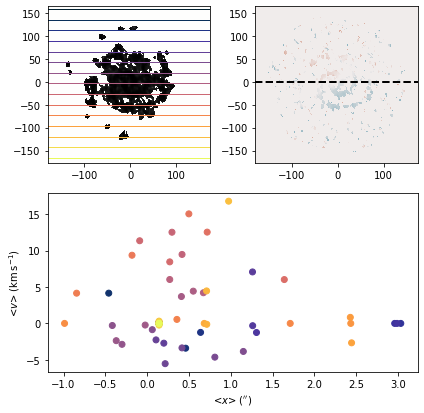

In [50]:
mydisc.plot_tw(slicing_name='N0628')

In [51]:
mydisc.slicings['N0628'].nslits

58

In [52]:
len(mydisc.slicings['N0628'].yedges), len(mydisc.slicings['N0628'].Omsini_tw)

(59, 58)

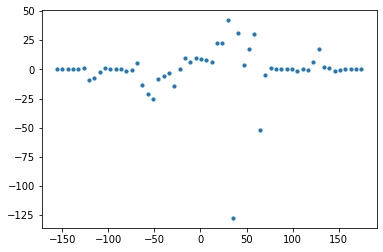

In [53]:
plt.scatter(mydisc.slicings['N0628'].yedges[1:], mydisc.slicings['N0628'].Omsini_tw, 10)
plt.show()

In [54]:
dir(mydisc.slicings['N4826'])

KeyError: 'N4826'

In [55]:
len(mydisc.slicings['N4826'].dfV_tw)

KeyError: 'N4826'

In [56]:
len(mydisc.slicings['N4826'].dfx_tw)

KeyError: 'N4826'

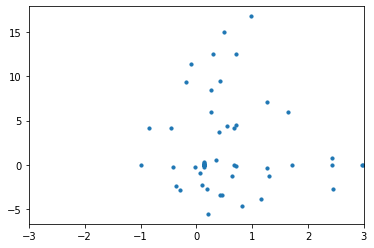

In [72]:
plt.scatter(mydisc.slicings['N0628'].dfx_tw, mydisc.slicings['N0628'].dfV_tw, 10)
plt.xlim(-3,3)
#plt.scatter(-0.25, -60, 20)
#plt.scatter(0, 40, 20)
#plt.plot([-0.4, 0.4], [-85, 85])
plt.show()

In [58]:
(85+85)/0.8

212.5

In [64]:
pix_kpc = bima_scale*dist_scale # kpc/pix

In [65]:
212.5*pix_kpc

10.137454072000397

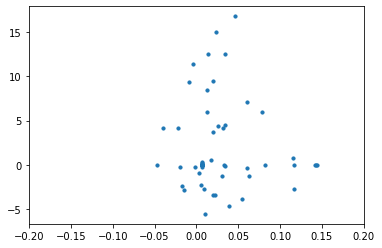

In [69]:
plt.scatter(mydisc.slicings['N0628'].dfx_tw*pix_kpc, mydisc.slicings['N0628'].dfV_tw, 10)
plt.xlim(-0.2,0.2)
# plt.scatter(-100, -20, 20)
# plt.scatter(70, 35, 20)
#plt.plot([-0.007, 0.008], [-85, 85])
plt.show()

In [36]:
(85+85)/(0.007+0.008)

11333.333333333334